# **Modeling Approach**

This notebook covers my modeling approach and would-be results for the PhysioNet 2012 Challenge. This notebook can be run using the data generated from `make_dataset.py` and `build_features.py`. I tried 4 different machine learning models to varying degrees of success, but at the end of the day, XGBoost performed the best with Logistic Regression as a close second.

#### **Table of Contents**
1. Data Preparation
2. Feature Selection
3. Model Selection
4. Model Evaluation
5. Model Interpretation
6. Conclusion


# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import os
import math
from tsfresh.feature_extraction import extract_features

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer
from sklearn.decomposition import PCA

from imblearn.ensemble import BalancedRandomForestClassifier

from xgboost import XGBClassifier

In [2]:
sns.set_style('darkgrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' #set figures to display in higher res

In [3]:
# import data and split out features and outcomes
filepath = os.path.join('.', 'data', 'processed', 'features_and_outcomes-a.csv')
df = pd.read_csv(filepath)
features = df.drop(['RecordID', 'In-hospital_death'], axis=1)
y = df['In-hospital_death']

In [64]:
# Create ScoreTracker class to store and plot performance of models
class ScoreTracker:
    
    def __init__(self):
        self.score_dict_ = {'model_name':[], 'mean_test_score':[], 'std_test_score':[], 'threshold':[]}
    
    def add_best_score(self, CV, model_name, threshold=np.nan):
        '''
        Adds mean and stddev of CV score for a CV object
        '''
        cv_results = pd.DataFrame(CV.cv_results_)
        mean_test_score = cv_results.loc[cv_results['rank_test_score']==1, 'mean_test_score'].iloc[0]
        std_test_score = cv_results.loc[cv_results['rank_test_score']==1, 'std_test_score'].iloc[0]
        self.score_dict_['model_name'].append(model_name)
        self.score_dict_['mean_test_score'].append(mean_test_score)
        self.score_dict_['std_test_score'].append(std_test_score)
        self.score_dict_['threshold'].append(threshold)
        
    def plot_scores(self):
        num_bars = len(self.score_dict_['model_name'])
        fig, ax = plt.subplots(figsize=(6, 0.4*num_bars))
        clrs = ['slategrey' if score < max(self.score_dict_['mean_test_score']) else 'seagreen' for score in self.score_dict_['mean_test_score']]
        ax.barh(self.score_dict_['model_name'], self.score_dict_['mean_test_score'],
                xerr=self.score_dict_['std_test_score'], color=clrs)
        ax.set_xlabel('Mean CV Score')
        plt.show()

    def get_score_df(self):
        return pd.DataFrame(self.score_dict_)

In [5]:
# define contest scoring for use in sklearn(minimum of precision and recall)
def contest_score_func(y, y_pred):
    return min(precision_score(y, y_pred), recall_score(y, y_pred))

contest_score = make_scorer(contest_score_func)

# Feature Selection

### Remove sparse features
Let's start out by using a baseline Logistic Regression model to see how dropping sparse features affects model performance

In [6]:
# use logistic regression as baseline model
lr = LogisticRegression(solver='liblinear', random_state=42)

lr_baseline_params = {
    'penalty':['l1', 'l2']
}

lr_baseline = GridSearchCV(estimator=lr, cv=3, param_grid=lr_baseline_params,
                            verbose=0, n_jobs=-1, scoring=contest_score,
                            return_train_score=False)

In [7]:
# create mean imputer and scaler
imp = SimpleImputer()
ss = StandardScaler()

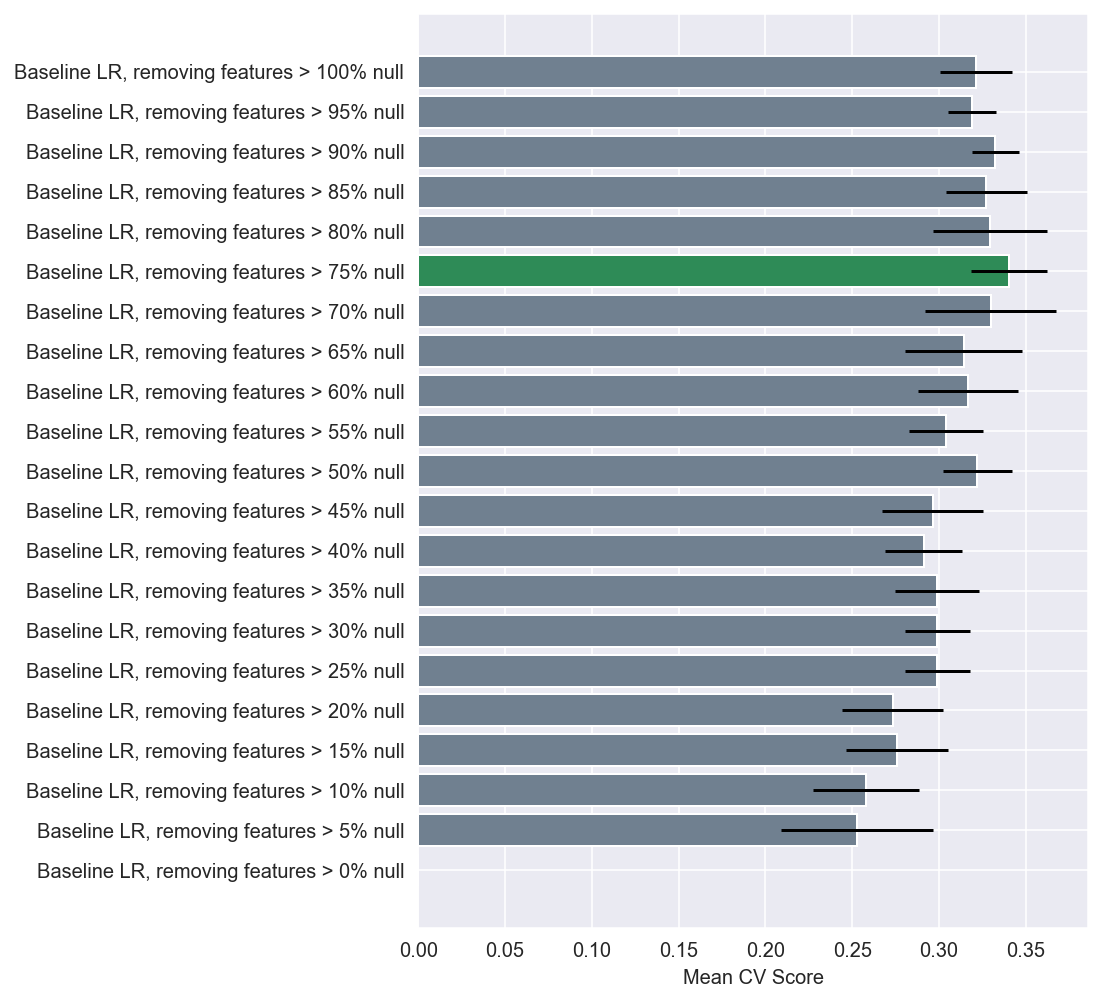

In [8]:
null_scores = ScoreTracker()

# try different null removal thresholds
for null_threshold in np.linspace(0, 1.0, 21):
    # remove sparse columns
    X = features.loc[:, features.isnull().mean() <= null_threshold]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # impute mean and standardize
    X_train_imp = imp.fit_transform(X_train)
    X_train_imp_ss = ss.fit_transform(X_train_imp)
    
    #test baseline model and add scores
    lr_baseline.fit(X_train_imp_ss, y_train)
    null_scores.add_best_score(lr_baseline, 'Baseline LR, removing features > {:2.0%} null'.format(null_threshold),
                               threshold=null_threshold)

null_scores.plot_scores()

Removing features that were more than 75% null yields the best Mean CV score, though it looks like the differences may not be statistically significant (just looking at the standard deviation of CV scores)

In [9]:
# select the null threshold that maximized score
null_scores_df = null_scores.get_score_df()
best_null_threshold = null_scores_df.loc[null_scores_df['mean_test_score'] == max(null_scores_df['mean_test_score']),
                                         'threshold'].mean()

# Remove sparse features based on best null threshold
X = features.loc[:, features.isnull().mean() <= best_null_threshold]

# perform train_test_split on data with nulls removed, ensure it is stratified because the dataset is imablanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)

In [10]:
print(features.shape)
print(X.shape)

(4000, 586)
(4000, 477)


After removing sparse features, we've dropped from 586 features to 477

In [11]:
# create mean imputed data
X_train_imp = imp.fit_transform(X_train)
X_test_imp = imp.transform(X_test)

# use standard scaling on imputed data
X_train_imp_ss = ss.fit_transform(X_train_imp)
X_test_imp_ss = ss.transform(X_test_imp)

### Investigate collinearity
After removing sparse features, it's clear that there are numerous collinear features (hot and cold spots in clustermap). I looked into the impact of removing collinear features (through PCA) on the baseline model performance

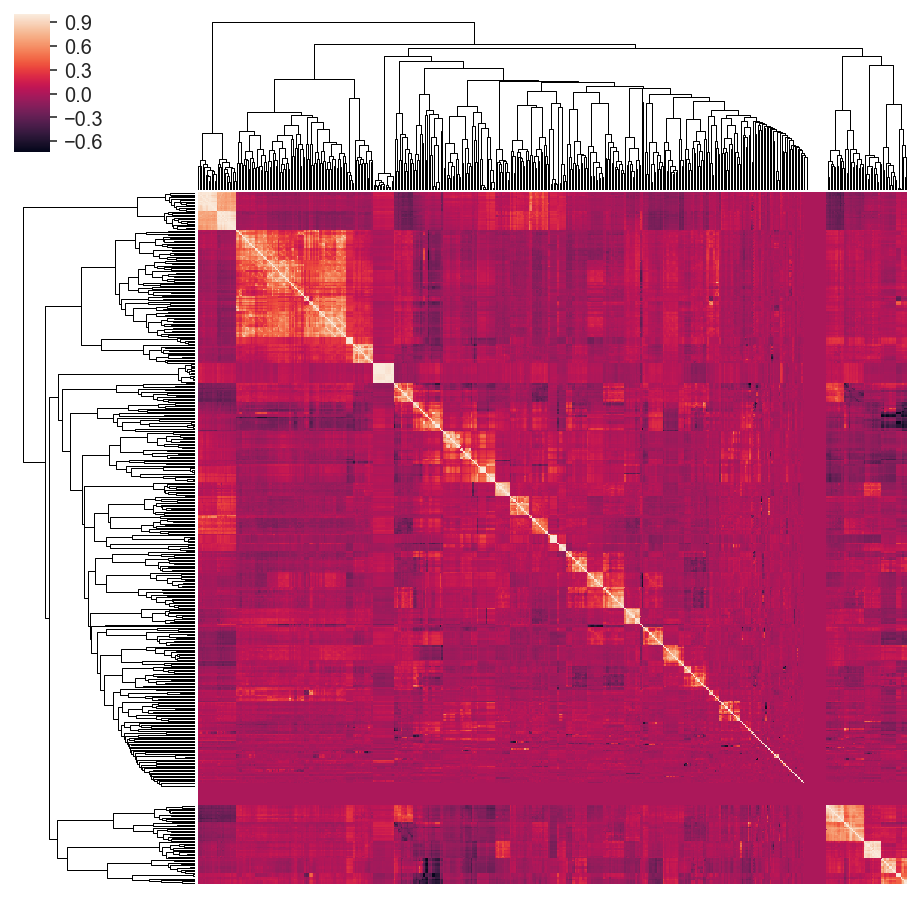

In [12]:
sns.clustermap(X.corr().fillna(0), figsize=(8,8), xticklabels=False, yticklabels=False)

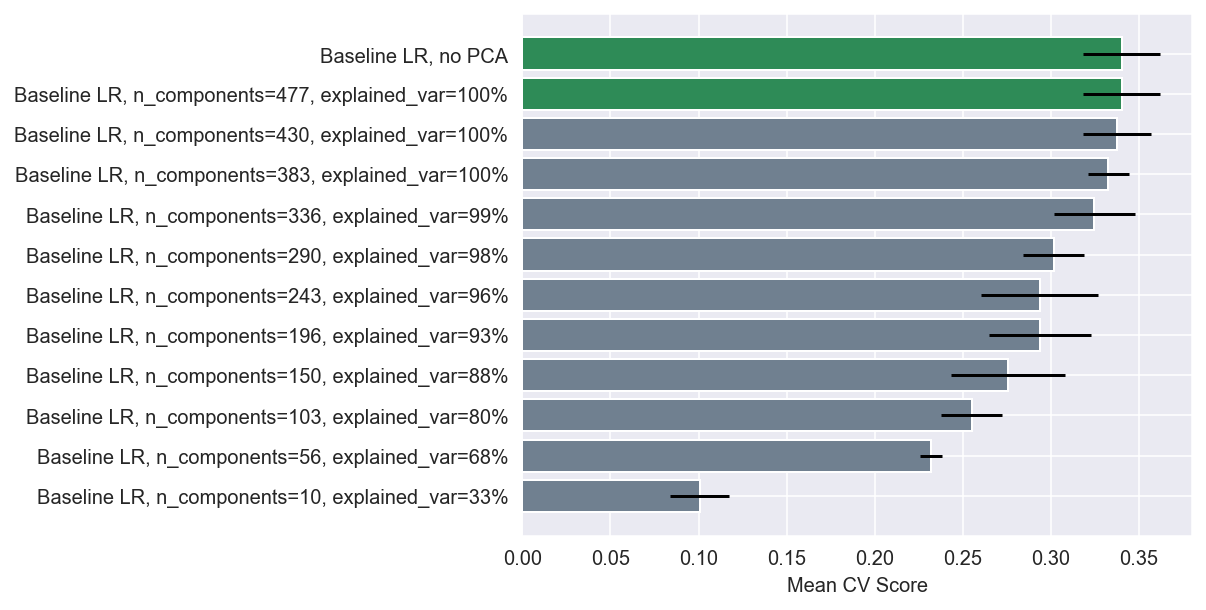

In [13]:
pca_scores = ScoreTracker()

# try different numbers of principal components
for n in np.linspace(10, len(X.columns), 11):
    # perform PCA
    pca = PCA(n_components=int(n))
    X_train_pca = pca.fit_transform(X_train_imp_ss)
    explained_var = sum(pca.explained_variance_ratio_)
    
    # test baseline model and add score
    lr_baseline.fit(X_train_pca, y_train)
    pca_scores.add_best_score(lr_baseline, 'Baseline LR, n_components={:}, explained_var={:2.0%}'.format(int(n), explained_var),
                              threshold=int(n))

# try no PCA
lr_baseline.fit(X_train_imp_ss, y_train)
pca_scores.add_best_score(lr_baseline, 'Baseline LR, no PCA')
    
pca_scores.plot_scores()

PCA doesn't improve model score, though one could argue that we could reduce the number of features to speed up model training while retaining the vast majority of the variance. However, we still want our features to remain interpretable, so PCA doesn't fit well into our workflow.

### Feature selection with Recursive Feature Elimination
Let's see how eliminating features affects model performance

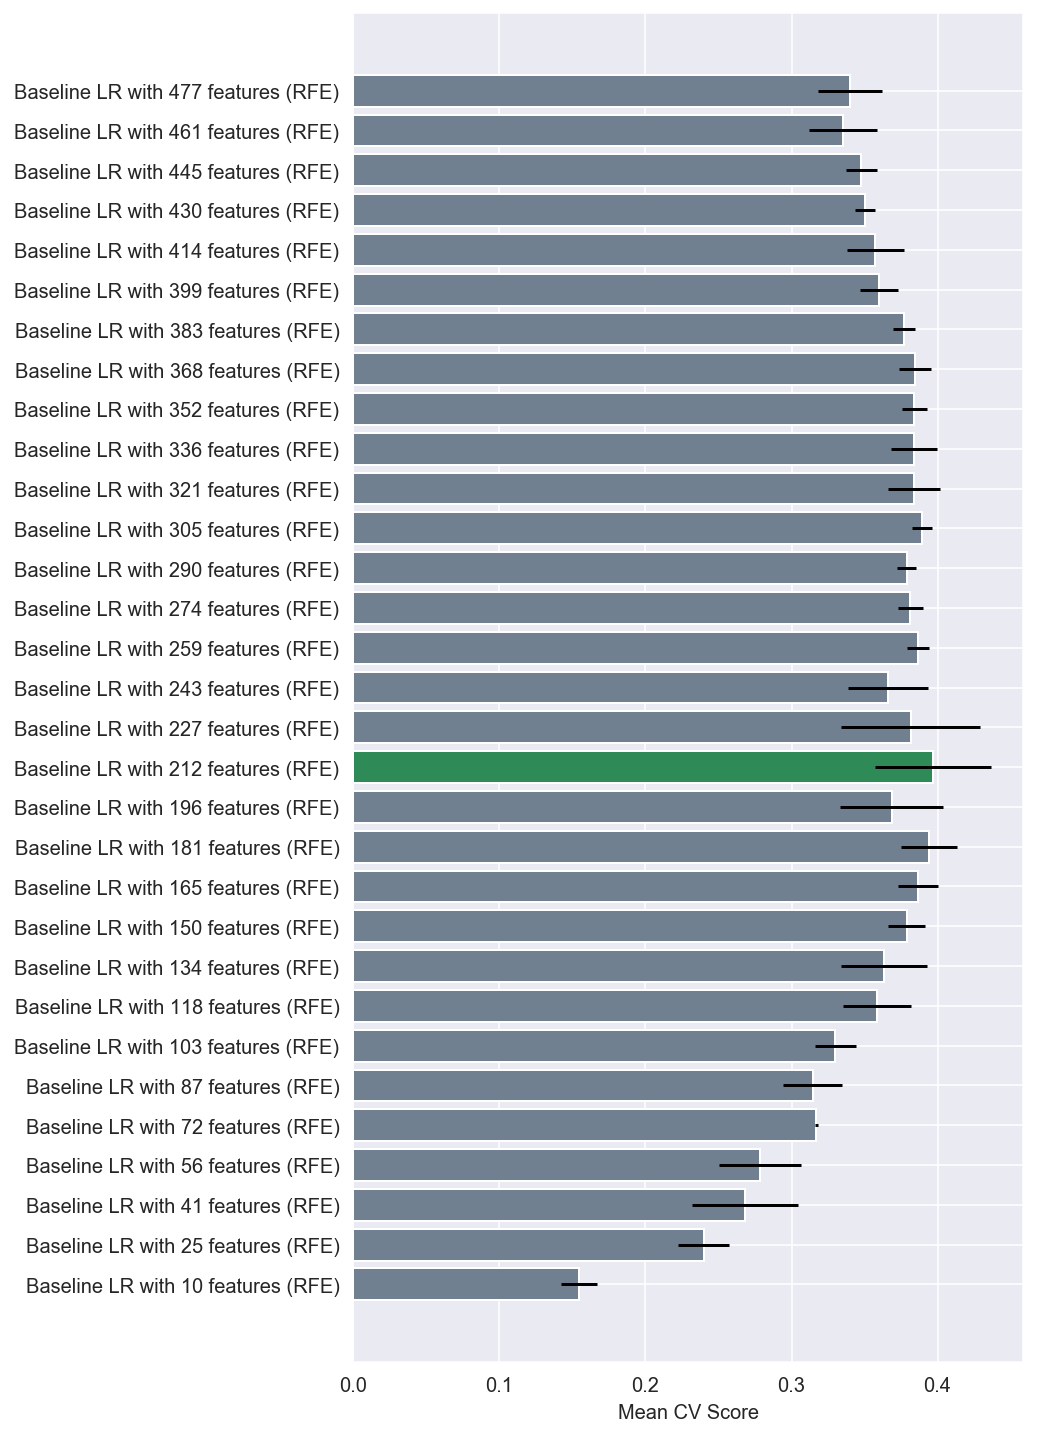

In [14]:
rfe_scores = ScoreTracker()

# try different numbers of features to select
for n in np.linspace(10, len(X.columns), 31):
    #remove features
    rfe = RFE(LogisticRegression(solver='liblinear', random_state=42), n_features_to_select=int(n), step=.1, verbose=0)
    rfe.fit(X_train_imp_ss, y_train)
    X_train_rfe = rfe.transform(X_train_imp_ss)
    
    # test baseline model and add score
    lr_baseline.fit(X_train_rfe, y_train)
    rfe_scores.add_best_score(lr_baseline, 'Baseline LR with {:} features (RFE)'.format(int(n)), threshold=int(n))

rfe_scores.plot_scores()

It seems like removing features does improve model performance. Based on these results, let's eliminate all but 212 features and use that dataset for modeling

In [15]:
# get best number of features from RFE
rfe_scores_df = rfe_scores.get_score_df()
best_n = rfe_scores_df.loc[rfe_scores_df['mean_test_score'] == max(rfe_scores_df['mean_test_score']), 'threshold'].mean()

# reduce to optimal number of features
rfe = RFE(LogisticRegression(solver='liblinear'), n_features_to_select=int(best_n), step=.1, verbose=0)
rfe.fit(X_train_imp_ss, y_train)
X_train_rfe = rfe.transform(X_train_imp_ss)
X_test_rfe = rfe.transform(X_test_imp_ss)

# Model Selection
So far, we've testing logistic regression as a baseline model using our contest score score. Now that we have our features pared down, it's time to test out different machine learning methods.

The following models are tested below:
* Logistic Regression
* Random Forest
* Balanced Random Forest
* XGBoost

### Baseline Models
The first step is to test our algorithms without tuning hyperparameters. 

In [16]:
# create score tracker
model_scores = ScoreTracker()

# create models 
lr = LogisticRegression(solver='liblinear', random_state=42)
rf = RandomForestClassifier(random_state=42)
brf = BalancedRandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

# create baseline parameters
lr_baseline_params = {
    'penalty':['l2']
}

rf_baseline_params = {
    'n_estimators': [100]
}

brf_baseline_params = rf_baseline_params

xgb_baseline_params = {
    'max_depth': [3]
}

# create baseline GridSearchCVs
lr_baseline = GridSearchCV(estimator=lr, cv=3, param_grid=lr_baseline_params,
                            verbose=0, n_jobs=-1, scoring=contest_score,
                            return_train_score=False)

rf_baseline = GridSearchCV(estimator=rf, cv=3, param_grid=rf_baseline_params,
                            verbose=0, n_jobs=-1, scoring=contest_score,
                            return_train_score=False)

brf_baseline = GridSearchCV(estimator=brf, cv=3, param_grid=brf_baseline_params,
                            verbose=0, n_jobs=-1, scoring=contest_score,
                            return_train_score=False)

xgb_baseline = GridSearchCV(estimator=xgb, cv=3, param_grid=xgb_baseline_params,
                            verbose=0, n_jobs=-1, scoring=contest_score,
                            return_train_score=False)

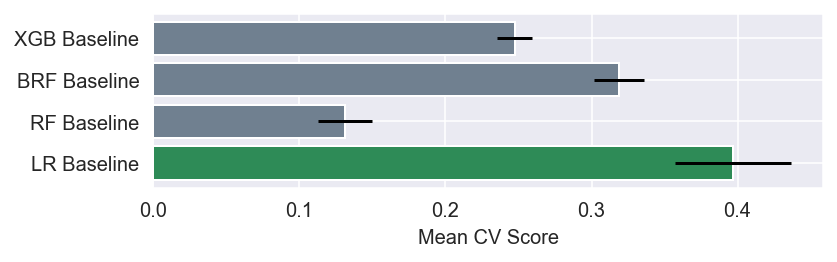

In [17]:
# test and plot baseline model performance
lr_baseline.fit(X_train_rfe, y_train)
rf_baseline.fit(X_train_rfe, y_train)
brf_baseline.fit(X_train_rfe, y_train)
xgb_baseline.fit(X_train_rfe, y_train)
model_scores.add_best_score(lr_baseline, 'LR Baseline')
model_scores.add_best_score(rf_baseline, 'RF Baseline')
model_scores.add_best_score(brf_baseline, 'BRF Baseline')
model_scores.add_best_score(xgb_baseline, 'XGB Baseline')

model_scores.plot_scores()

It looks like logistic regression is performing the best out of the box, and random forest is performing the worst. Given that our classes are imbalanced, this isn't surprising. The next step is to tune hyperparameters using a random search / Grid Search

### Hyperparameter Tuning

In [18]:
# define function to fit CV objects and display the best score and parameters
def score_CV(CV, X_test, y_test, scoretracker, model_name):
    CV.fit(X_test, y_test)
    model_scores.add_best_score(CV, model_name)
    model_scores.plot_scores()
    print(model_name + ' best parameters:')
    print(CV.best_params_)

For tuning the Logistic Regression model, I started with a grid search since there are only 2 hyperparameters to tune

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  67 out of  90 | elapsed:    6.8s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   20.0s finished


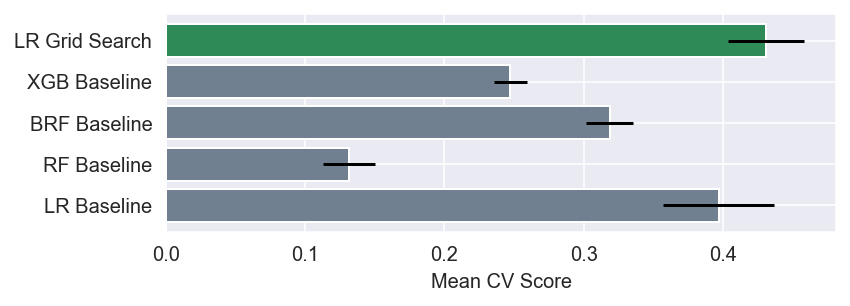

LR Grid Search best parameters:
{'C': 0.001, 'penalty': 'l2'}


In [19]:
# parameters used for Logistic Regression grid search
lr_grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [10**x for x in np.linspace(-4, 3, 15)]
}

lr_grid = GridSearchCV(estimator=lr, cv=3, param_grid=lr_grid_params,
                       verbose=1, n_jobs=-1, scoring=contest_score,
                       return_train_score=False)

score_CV(lr_grid, X_train_rfe, y_train, scoretracker=model_scores, model_name='LR Grid Search')

For tuning RandomForest, BalancedRandomForest, and XGBoost, I start with a RandomSearch to understand the range of optimal values for each hyperparameter, then perform a more targeted GridSearch on the best performing model after the Random Search

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  9.7min
/Users/johnchow/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 14.3min finished


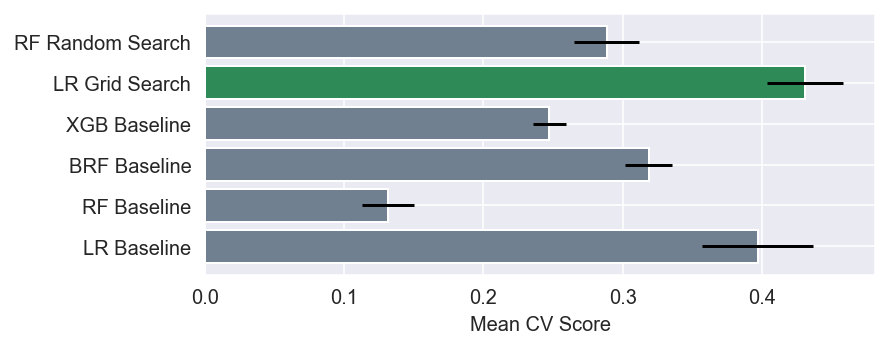

RF Random Search best parameters:
{'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 16, 'bootstrap': True}


In [20]:
# params used for both RandomForest and BalancedRandomForest
forest_random_params = {
    'n_estimators': [10, 40, 100, 400, 1000],
    'max_depth': [4, 8, 16, 32, 64, 128, None],
    'min_samples_split': [2, 8, 16, 32, 128],
    'min_samples_leaf': [1, 2, 8, 32, 128], 
    'max_features': ['auto', 'log2', None],
    'bootstrap': [True]
}

rf_random = RandomizedSearchCV(rf, forest_random_params, n_iter=200,
                          scoring=contest_score, verbose=1, n_jobs=-1,
                          cv=3, random_state=42)

score_CV(rf_random, X_train_rfe, y_train, scoretracker=model_scores, model_name='RF Random Search')

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.8min finished


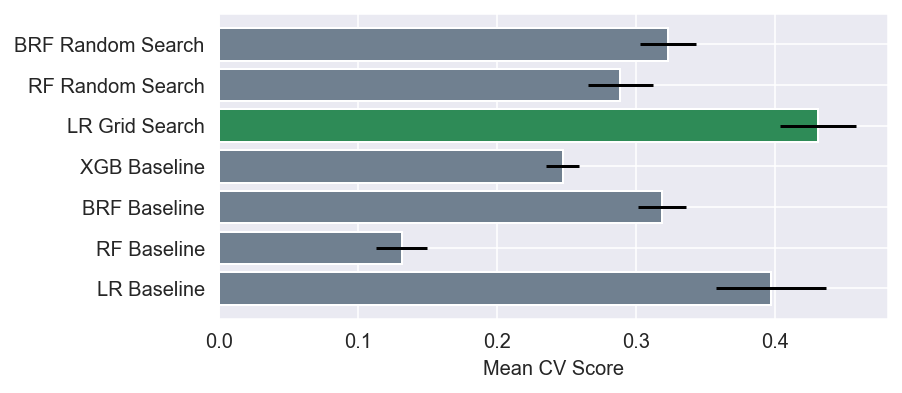

BRF Random Search best parameters:
{'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 8, 'bootstrap': True}


In [21]:
brf_random = RandomizedSearchCV(brf, forest_random_params, n_iter=200,
                          scoring=contest_score, verbose=1, n_jobs=-1,
                          cv=3, random_state=42)

score_CV(brf_random, X_train_rfe, y_train, scoretracker=model_scores, model_name='BRF Random Search')

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
/Users/johnchow/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/Users/johnchow/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  6.6min finished


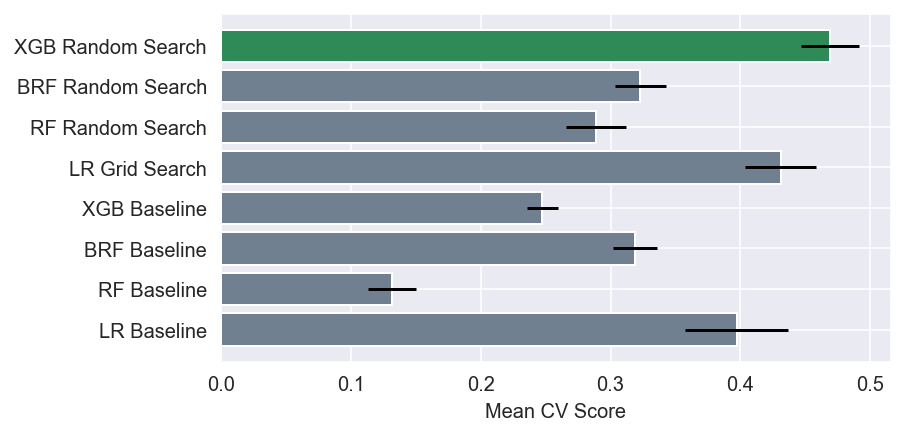

XGB Random Search best parameters:
{'subsample': 0.5, 'scale_pos_weight': 4, 'reg_lambda': 1e-05, 'reg_alpha': 0.01, 'n_estimators': 50, 'min_child_weight': 9, 'max_depth': 16, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9}


In [22]:
# parameters used for XGBoost Random Search
xgb_random_params = {
    'n_estimators': [10, 50, 100, 400, 1000],
    'learning_rate': [.01, .03, .06, .1, .13, .16, .2],
    'subsample': np.linspace(0.1, 1, 10),
    'max_depth': [2, 3, 5, 8, 12, 16],
    'colsample_bytree': np.linspace(0.1, 1, 10),
    'gamma': [0, 0.1, 1, 5],
    'min_child_weight': [1, 3, 5, 7, 9],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100, 300],
    'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100, 300],
    'scale_pos_weight': [1, 2, 4, 8, 10]
}

xgb_random = RandomizedSearchCV(xgb, xgb_random_params, n_iter=200,
                          scoring=contest_score, verbose=1, n_jobs=-1,
                          cv=3, random_state=42)

score_CV(xgb_random, X_train_rfe, y_train, scoretracker=model_scores, model_name='XGB Random Search')

At this point, we've run random searches on RandomForest, BalancedRandomForest, and XGBoost, with XGBoost performing the best out of these 3. Interestingly, our optimized LogisticRegression is not actually too far behind. A few takeaways from this:
* We'll continue to optimize our XGBoost model through a grid search, and drop the RandomForest and BalancedRandomForest as their performance remains weak after the random search.
* In the tradeoff between performance and interpretability, there's an argument to go with the LogisticRegression as it is easier to interpret than the XGBoost model. However, since we're aiming to maximize our contest score, we'll stick with fully optimizing and evaluating our XGBoost model. It will be interesting to see how our LogisticRegression would have performed.

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 5184 out of 5184 | elapsed: 21.1min finished


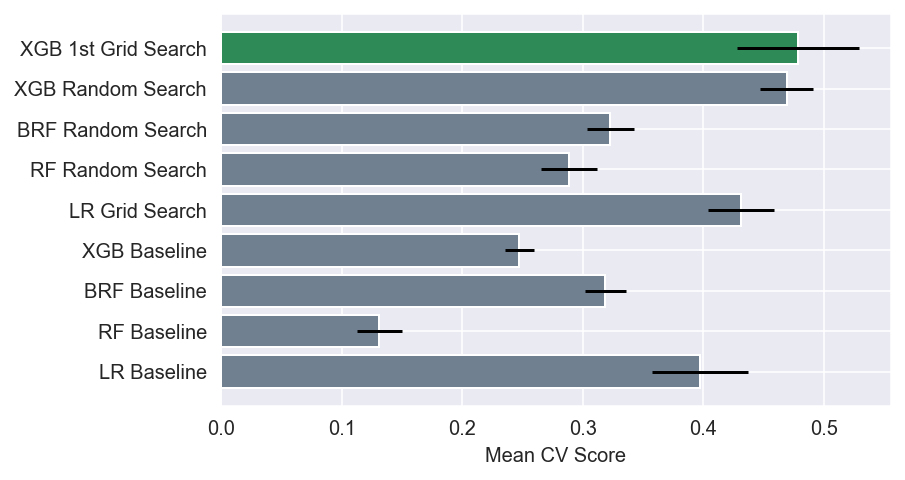

XGB 1st Grid Search best parameters:
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 16, 'min_child_weight': 12, 'n_estimators': 75, 'reg_alpha': 0.01, 'reg_lambda': 1e-06, 'scale_pos_weight': 4, 'subsample': 0.4}


In [24]:
xgb_grid_params = {
    'n_estimators': [30, 50, 75],
    'learning_rate': [0.1],
    'subsample': [0.4, 0.5, 0.6],
    'max_depth': [16, 20],
    'colsample_bytree': [0.8, 0.9, 1],
    'gamma': [0, 0.1],
    'min_child_weight': [9, 12],
    'reg_alpha':[0.01, 0.1],
    'reg_lambda':[1e-6, 1e-5],
    'scale_pos_weight': [4, 8]
}

xgb_grid = GridSearchCV(xgb, xgb_grid_params, scoring=contest_score,
                        verbose=1, n_jobs=-1, cv=3, return_train_score=True)

score_CV(xgb_grid, X_train_rfe, y_train, scoretracker=model_scores, model_name='XGB 1st Grid Search')

Going off of these grid search results, let's perform a final grid search to see if we can further improve model performance

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.4min finished


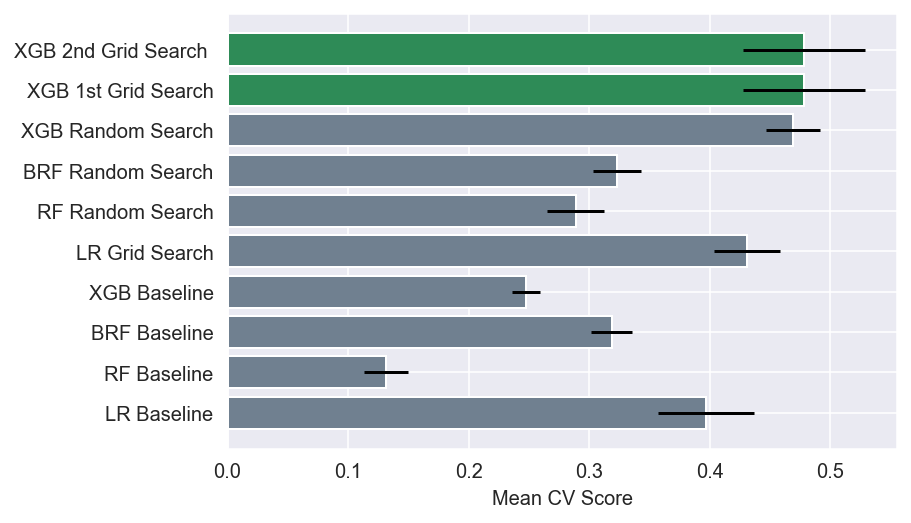

XGB 2nd Grid Search  best parameters:
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 16, 'min_child_weight': 12, 'n_estimators': 75, 'reg_alpha': 0.01, 'reg_lambda': 1e-07, 'scale_pos_weight': 4, 'subsample': 0.4}


In [26]:
xgb_grid_params = {
    'n_estimators': [75, 100, 150],
    'learning_rate': [.1],
    'subsample': [0.3, 0.4],
    'max_depth': [16],
    'colsample_bytree': [.7, .8],
    'gamma': [0.1],
    'min_child_weight': [12, 15],
    'reg_alpha':[0.01, .001],
    'reg_lambda':[1e-7, 1e-06],
    'scale_pos_weight': [4]
}

xgb_grid = GridSearchCV(xgb, xgb_grid_params, scoring=contest_score,
                        verbose=1, n_jobs=-1, cv=3, return_train_score=True)

score_CV(xgb_grid, X_train_rfe, y_train, scoretracker=model_scores, model_name='XGB 2nd Grid Search ')

The same parameters from our 1st grid search are still the best, so it seems like we've hit diminishing returns on hyperparameter tuning. Let's try evaluating our best model against the test data.

# Model Evaluation
### Train/Test Data
The goal of the contest is to maximize the minimum of recall and precision, though it's important to note that the classification threshold we use could really affect our scores. The approach to maximizing our score should be to find the classification threshold that maximizes the contest score on a training set, then see how the model scores on our test set using that optimal threshold.

In [27]:
# define a few helper functions to measure model performance at different classification thresholds

def get_best_threshold(fit_model, X_test, y_test):
    '''
    Given a fit model, returns classification threshold that maximizes contest score for X_test, y_test
    '''
    predicted_probs = fit_model.predict_proba(X_test)[:,1]
    best_score = -1
    best_threshold = -1
    best_precision = -1
    best_recall = -1
    best_f1 = -1
    for threshold in np.linspace(0,1,1001):
        preds_at_threshold = (predicted_probs >= threshold).astype(int)
        if sum(preds_at_threshold) == 0: 
            pass
        else:
            f1 = f1_score(y_test, preds_at_threshold)
            precision = precision_score(y_test, preds_at_threshold)
            recall = recall_score(y_test, preds_at_threshold)
            contest_score = min(precision, recall) # use the scoring system of the actual competiton
            if contest_score > best_score:
                best_score = contest_score
                best_threshold = threshold
                best_precision = precision
                best_recall = recall
                best_f1 = f1
    print(type(fit_model).__name__)
    print('Max Contest Score of {:2.2%} at threshold of {:2.2%}'.format(best_score, best_threshold))
    print('(Precision: {:2.2%} | Recall: {:2.2%} | F1: {:2.2%}))'.format(best_precision, best_recall, best_f1))
    return best_threshold

def get_score_at_threshold(fit_model, X_test, y_test, threshold):
    '''
    Given a fit model and classification threshold, returns contest score by predicting probabilities for
    X_test, y_test at the given threshold
    '''
    predicted_probs = fit_model.predict_proba(X_test)[:,1]
    preds_at_threshold = (predicted_probs >= threshold).astype(int)
    precision = precision_score(y_test, preds_at_threshold)
    recall = recall_score(y_test, preds_at_threshold)
    f1 = f1_score(y_test, preds_at_threshold)
    score = min(precision, recall)
    print(type(fit_model).__name__)
    print('Contest Score of {:2.2%} at threshold of {:2.2%}'.format(score, threshold))
    print('(Precision: {:2.2%} | Recall: {:2.2%} | F1: {:2.2%}))'.format(precision, recall, f1))
    print('\n')

In [28]:
# get best XGBoost model
best_xgb = xgb_grid.best_estimator_

# split our training set into a train and cv set to use for early stopping
X_tr_rfe, X_cv_rfe, y_tr, y_cv = train_test_split(X_train_rfe, y_train, test_size=0.25, random_state=42)

# fit our best model to the smaller training set, using our cv set to determine when we're overfitting
best_xgb.fit(X_tr_rfe, y_tr, early_stopping_rounds=10, eval_set=[(X_cv_rfe, y_cv)], verbose=False)

# get the threshold that maximizes model score on our cv data
best_threshold = get_best_threshold(best_xgb, X_cv_rfe, y_cv)

XGBClassifier
Max Contest Score of 50.00% at threshold of 51.90%
(Precision: 50.00% | Recall: 50.56% | F1: 50.28%))


In [29]:
# check our model performance on the test data that it hasn't seen
get_score_at_threshold(best_xgb, X_test_rfe, y_test, best_threshold)

XGBClassifier
Contest Score of 47.93% at threshold of 51.90%
(Precision: 47.93% | Recall: 48.80% | F1: 48.36%))




Based on our train/cv/test data, we expect our contest score to be ~48% with our XGBoost model

### Final Model Evaluation on Contest Hold-out Dataset
The actual hold-out dataset used in the contest was made available, so let's see how our best performing model would have scored in the competition.

In [30]:
# import final validation set used in competition
filepath = os.path.join('.', 'data', 'processed', 'features_and_outcomes-c.csv')
df_final = pd.read_csv(filepath)
features_final = df_final.drop(['RecordID', 'In-hospital_death'], axis=1)
y_final = df_final['In-hospital_death']


# Remove sparse features, matching columns removed from set-a data
X_final = features_final.loc[:, [col for col in X.columns]]

# impute and scale
imp.fit(X)
X_imp = imp.transform(X)
X_final_imp = imp.transform(X_final)

ss.fit(X_imp)
X_imp_ss = ss.transform(X_imp)
X_final_imp_ss = ss.transform(X_final_imp)

# Select features using rfe
rfe.fit(X_train_imp_ss, y_train)
X_rfe = rfe.transform(X_imp_ss)
X_final_rfe = rfe.transform(X_final_imp_ss)

In [31]:
# fit best xgb model
best_xgb.fit(X_train_rfe, y_train, early_stopping_rounds=10, eval_set=[(X_test_rfe, y_test)], verbose=False)

# find best threshold for test data
best_threshold = get_best_threshold(best_xgb, X_test_rfe, y_test)

XGBClassifier
Max Contest Score of 51.81% at threshold of 53.80%
(Precision: 51.81% | Recall: 51.81% | F1: 51.81%))


In [32]:
# check final contest score
get_score_at_threshold(best_xgb, X_final_rfe, y_final, best_threshold)

XGBClassifier
Contest Score of 46.50% at threshold of 53.80%
(Precision: 50.56% | Recall: 46.50% | F1: 48.44%))




**Our XGBoost model had a final score of 46.50%,** so it looks like we would have placed 8th in the competition. Not bad, except for the fact that it took place in 2012.

Given that our logistic regression also had respectable performance, let's see how it would have placed in the competition.

In [33]:
best_lr = lr_grid.best_estimator_

best_lr.fit(X_rfe, y)

# find best threshold for training data
best_threshold_lr = get_best_threshold(best_lr, X_rfe, y)

LogisticRegression
Max Contest Score of 51.08% at threshold of 47.50%
(Precision: 51.08% | Recall: 51.08% | F1: 51.08%))


In [34]:
# check final contest score
get_score_at_threshold(best_lr, X_final_rfe, y_final, best_threshold_lr)

LogisticRegression
Contest Score of 49.74% at threshold of 47.50%
(Precision: 51.41% | Recall: 49.74% | F1: 50.56%))




Interestingly, our logistic regression would have actually outperformed our XGBoost model if we had entered it. However, the fact that our expected contest score was slightly lower (51.08% vs 51.81%) means that we wouldn't have chosen it as our final entry.

# Model Interpretation
Now that we're figured out our model performance, let's look into what features our models are using to drive predictions

In [35]:
def plot_feature_importances(fit_model, X_train):
    '''
    Plots a bar chart of the top feature importances from `fit_model`, 
    ordered by descending importance, labeled with `X_train` column names 
    '''
    feat_importance_df = pd.DataFrame(fit_model.feature_importances_)
    feat_importance_df.index = X_train.columns
    feat_importance_df.index.name = 'feature'
    feat_importance_df.columns = ['importance']
    feat_importance_df = feat_importance_df.sort_values(by='importance', ascending=False).head(30).reset_index()
    fig, ax = plt.subplots(figsize = (7,10))
    sns.barplot(data=feat_importance_df, y='feature', x='importance', ax=ax, color='steelblue')
    ax.set_xlabel('{} Feature Importance'.format(type(fit_model).__name__))

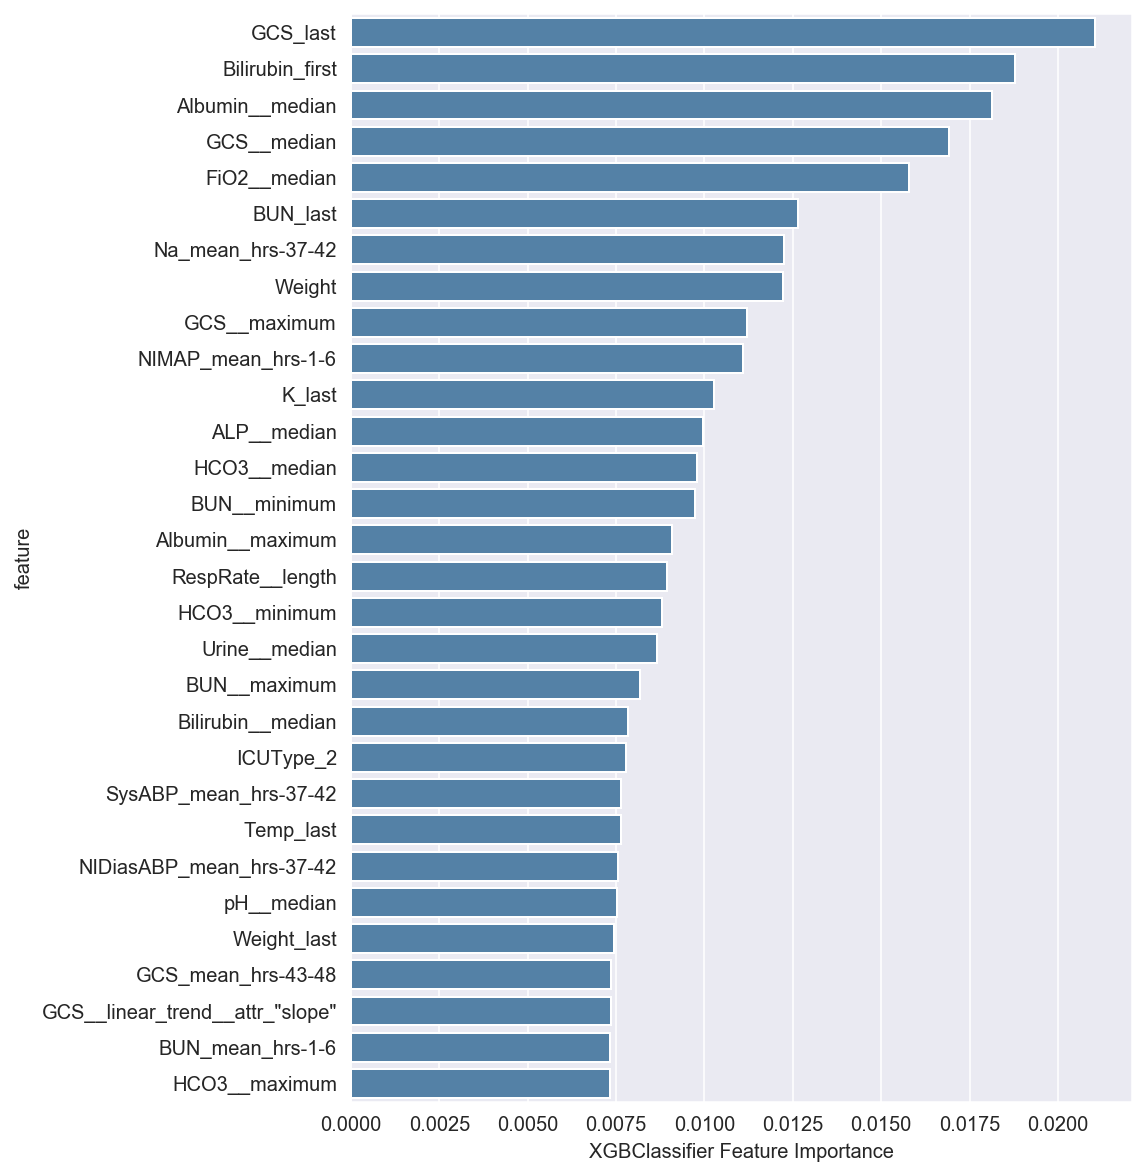

In [36]:
features_list = X_train.loc[:, rfe.get_support()] # get feature names that were kept after RFE

plot_feature_importances(best_xgb, features_list)

The last GCS reading is of highest value to our XGBoost model. This makes some sense, as the GCS (Glasgow Coma Scale) is a measurement of a patient's level of consciousness. 

Given that our LogisticRegression Model performed quite well, it'll also be interesting to see what features are important there, and how the 2 models differ

In [37]:
def plot_lr_coefs(lr, X_train):
    '''
    Plots a bar chart of regression coefficients from `lr`, ordered in 
    descending absolute value, labeled with `X_train` column names 
    '''
    df_lr = pd.DataFrame(lr.coef_).transpose()
    df_lr.index = X_train.columns
    df_lr.index.name = 'feature'
    df_lr.columns = ['coef_val']
    df_lr['abs_coef_val'] = df_lr['coef_val'].apply(np.abs)
    df_lr['is_coef_positive'] = np.where(df_lr['coef_val'] > 0, 'Positive Coef', 'Negative Coef')
    df_lr = df_lr.sort_values('abs_coef_val', ascending=False).head(30).reset_index()
    fig, ax = plt.subplots(figsize=(7,10))
    sns.barplot(data=df_lr, y='feature', x='coef_val', ax=ax, color='steelblue')
    ax.set_xlabel('Coefficient (Logistic Regression)')
    plt.show()

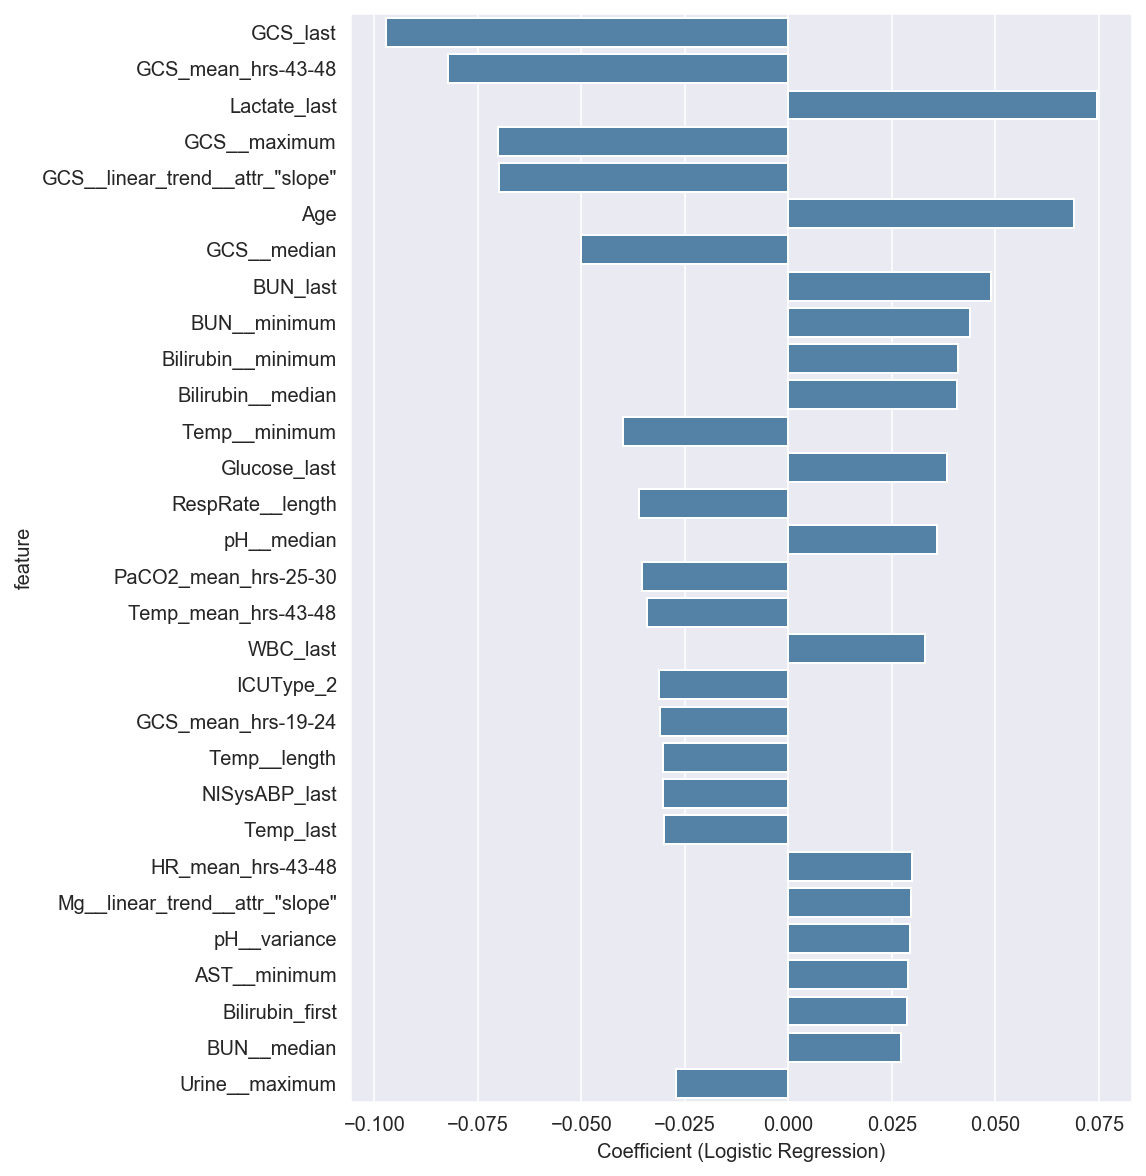

In [38]:
plot_lr_coefs(best_lr, features_list)

Similar to our XGBoost model, the last and later GCS values rise to the top. However, that's where the similarities begin to diverge - our LR model has Lactate and Age rising to the top, whereas these features do not show up in the most important features for our XGBoost Classifier. Let's see if we can visualize the differences between models in a scatterplot of importances

In [61]:
def plot_feature_scatter(model, lr, X_train):
    feat_importance_df = pd.DataFrame(model.feature_importances_)
    feat_importance_df.index = X_train.columns
    model_colname = '{} Feature Importance (abs. val, standardized)'.format(type(model).__name__)
    feat_importance_df.columns = [model_colname]
    df_lr = pd.DataFrame(lr.coef_).transpose()
    df_lr.index = X_train.columns
    lr_colname = '{} Coefficient (abs. val, standardized)'.format(type(lr).__name__)
    df_lr.columns = [lr_colname]
    merged = pd.merge(feat_importance_df, df_lr, left_index=True, right_index=True
                      , validate='1:1')
    merged.iloc[:,1] = merged.iloc[:,1].apply(np.abs)
    merged=(merged-merged.mean())/merged.std()
    merged.reset_index(inplace=True)
    fig = px.scatter(data_frame=merged, x=model_colname,
                     y=lr_colname, hover_name='feature',
                     width=600, height=600)
    fig.show()

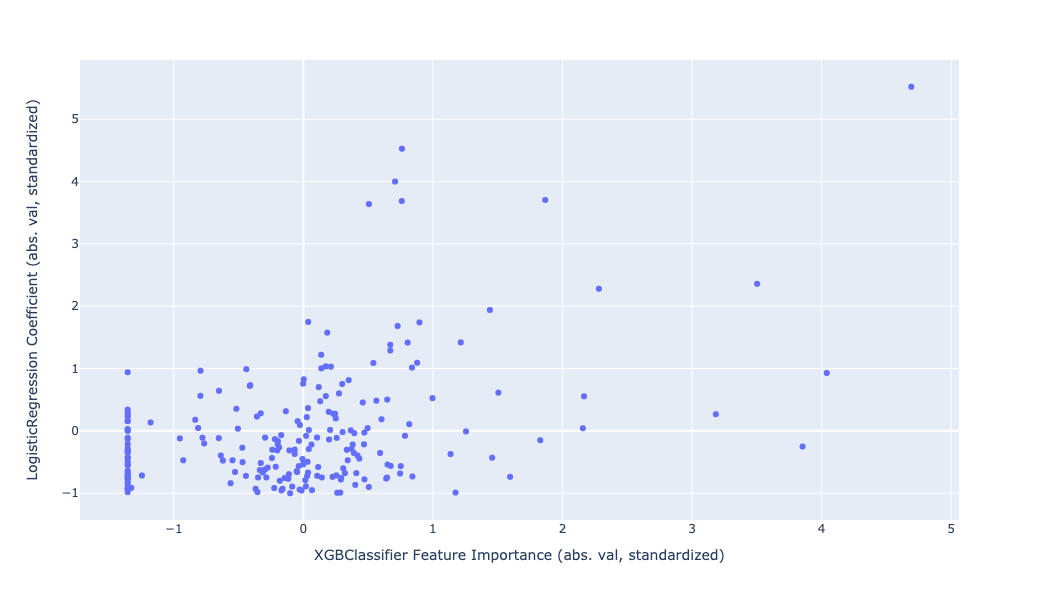

In [62]:
plot_feature_scatter(best_xgb, best_lr, features_list)

From the scatterplot, we can see a few features that are equally important for both the Logistic Regression and XGBoost Model. The most important feature for both models is `GCS__last`, followed by a toss-up of `GCS__median` and `GCS__maximum`, depending on which model's priority you're looking at. Other features that were found to be important for both models include `BUN_last` and `BUN_minimum`. 

From this plot, we can also see features that one model finds important but the other does not. A few stand out as features found important by our XGBoost model but that don't have large coefficients for our Logistic Regression:
* `Bilirubin_first`
* `FiO2__median`
* `Albumin__median`

And similarly, there are a few features that the Logistic Regression gives large coefficients but that don't have a high importance for our XGBoost Model.
* `GCS_mean_hrs-43-48`
* `Lactate_last`
* `Age`
* `GCS_Slope`

These are some interesting differences and I'd like to delve deeper into these. My first hunch is that some of these differences are due to the fact that a having a feature with a large coefficient after Logistic Regression doesn't necessarily mean that the feature is important for predictions. Fo example, the feature could have very low variance - say, lots of zeroes - but the rare non-zero values do strongly predict the outcome. Here, the feature would have a large coefficient for Logistic Regression but might not have a high importance for XGBoost and other tree-based methods. 

I'm sure there are others reasons for these differences (perhaps XGBoost overfitting?) so if you know of any, please let me know!

# Conclusion

Predicting in-hospital mortality using patient timeseries data has been an interesting exercise. Out of the 4 model approaches we tried, Logistic Regression and XGBoost performed the best. After completing the modeling, I'm still left with some unanswered questions and potential improvements that I'd like to expore in the future.

### Lingering Questions
1. Why did Balanced Random Forest and Random Forest underperform Logistic Regression, and how can one correct for this?
2. Why do some features with high importance from XGBoost have small coefficients in the Logistic Regression model, and vice versa?

### Potential Improvements
* Using a more sophisticated null imputation method (e.g., MICE) rather than mean imputation
* Using a more sophisticated modeling approach (deep learning)
* Using a systematic approach to XGBoost hyperparmeter tuning, perhaps tuning a few parameters at a time over multiple grid searches
* Improving feature engineering 
    * Getting feedback from an expert with more domain knowledge to engineer clever features
    * Using signal processing techniques
    * Engineering fewer features?
* Improving feature selection method
    * Could be useful to optimize sparse feature removal and RFE using a tree-based baseline model as well as a Logistic Regression
* Using statistical tests to compare if an improvement in model score is significantly different from another model
* Removing more outliers